# Hypothesis Testing with Insurance Data (Core)

- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy
scipy.__version__

'1.9.3'

In [2]:
# Load Data
df = pd.read_csv('insurance - insurance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# - Q1. Do smokers have higher insurance charges than non-smokers?

1. State the Hypothesis & Null Hypothesis

(Null Hypothesis): There is no difference in higher insurance charges between smokers and non-smokers. 

(Alternative Hypothesis): There is a significant difference in higher insurance charges between smokers and non-smokers.

2. Determine the correct test to perform.

 - Numerical Data
 - Two groups/samples
 - We want to run a 2-sample T-test.



## Visualize and separate data for hypothesis

In [3]:
df['smokes'] = df['smoker'].str.contains('yes')
df['smokes'].value_counts()

False    1064
True      274
Name: smokes, dtype: int64

In [4]:
## save list of columns needed for each group
needed_cols = ['smokes','charges']

df[needed_cols]

,smokes,charges
0,True,16884.92400
1,False,1725.55230
2,False,4449.46200
3,False,21984.47061
4,False,3866.85520
...,...,...
1333,False,10600.54830
1334,False,2205.98080
1335,False,1629.83350
1336,False,2007.94500


In [5]:
## save non-smoker group in separate variable
non_smoker = df.loc[df['smokes']==False, needed_cols]
non_smoker

,smokes,charges
1,False,1725.55230
2,False,4449.46200
3,False,21984.47061
4,False,3866.85520
5,False,3756.62160
...,...,...
1332,False,11411.68500
1333,False,10600.54830
1334,False,2205.98080
1335,False,1629.83350


In [6]:
## save smoker group in separate variables
does_smoke = df.loc[df['smokes']==True, needed_cols]
does_smoke

,smokes,charges
0,True,16884.92400
11,True,27808.72510
14,True,39611.75770
19,True,36837.46700
23,True,37701.87680
...,...,...
1313,True,36397.57600
1314,True,18765.87545
1321,True,28101.33305
1323,True,43896.37630


<Axes: xlabel='smoker', ylabel='charges'>

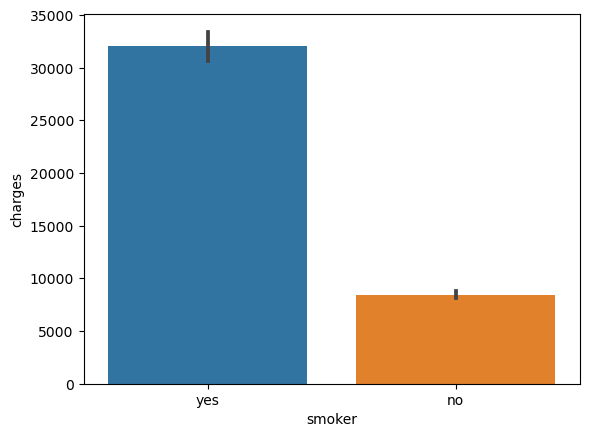

In [19]:
## visualize the group means
sns.barplot(data=df, x='smoker', y='charges')

## Testing Assumptions

   - No significant outliers
   - Normality
   - Uneven Variance



In [9]:
smoker_group = does_smoke['charges']
non_smoker_group =  non_smoker['charges']
non_smoker_group

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

In [10]:
# Check female group for outliers
smoker_outlier = np.abs(stats.zscore(smoker_group)) > 3
smoker_outlier.sum()

0

In [11]:
# Check female group for outliers
non_smoker_outlier = np.abs(stats.zscore(non_smoker_group)) > 3
non_smoker_outlier.sum()

24

In [12]:
# Remove outliers from non smoker group
non_smoker_group = non_smoker_group.loc[~non_smoker_outlier]
non_smoker_group

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

## Test for Normality

In [13]:
# Check smoker group for normality
result = stats.normaltest(smoker_group)
result.pvalue

5.564930630036463e-14

In [14]:
# Check n for smoker group
len(smoker_group)

274

In [15]:
# Check non-smoker group for normality
result = stats.normaltest(non_smoker_group)
result.pvalue

2.6945416315543976e-36

In [16]:
# Check n for non-smoker group
len(non_smoker_group)

1040

Since our p-values from our normality test are small it shows evidence against the null hypothesis in favor of the alternative.

Are groups are large enough that we can safely disregard the assumption of normality.



## Test for Equal Variances

In [17]:
# Use Levene's test for equal variance
result = stats.levene(smoker_group, non_smoker_group)
print(result)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


In [18]:
# Interpret the p-value
if result.pvalue < .05:
    print(f"The groups do NOT have equal variance.")
else:
    print(f"The groups DO have equal variance.")

The groups do NOT have equal variance.


- We NOT meet the assumption of equal variance.
- We will therefore run a Welch's t-test instead by adding equal_var=False to stats.ttest_ind



## Final Hypothesis Test - Welch's T-Test


In [20]:
result = stats.ttest_ind(smoker_group, non_smoker_group, equal_var=False)
print(result)
result.pvalue  < .05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

In [21]:
smoker_group.mean()

32050.23183153284

In [22]:
non_smoker_group.mean()

7939.8608446721155

We had a p-value < .05 for our welch's t-test. We reject the null hypothesis and support the alternative that there is a significant difference in higher insurance charges between smokers and non-smokers.
